# Code

**Date: February, 2017**

In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.gridspec as gsp
import seaborn as sns
import pandas as pd

# For linear regression
from scipy.stats import multivariate_normal
from scipy.integrate import dblquad

# Shut down warnings for nicer output
import warnings
warnings.filterwarnings('ignore')

colors = sns.color_palette()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

**Coin tossing example**

In [2]:
#===================================================
# FUNCTIONS
#===================================================

def relative_entropy(theta0, a):
    return theta0 * np.log(theta0/a) + (1 - theta0) * np.log((1 - theta0)/(1 - a))

def quadratic_loss(theta0, a):
    return (a - theta0)**2

def loss_distribution(l, dr, loss, true_dist, theta0, y_grid):
    """
    Uses the formula for the change of discrete random variable. It takes care of the 
    fact that relative entropy is not monotone.
    """
    eps = 1e-16
    if loss == 'relative_entropy':
        a1 = sp.optimize.bisect(lambda a: relative_entropy(theta0, a) - l, a = eps, b = theta0)
        a2 = sp.optimize.bisect(lambda a: relative_entropy(theta0, a) - l, a = theta0, b = 1 - eps)
    elif loss == 'quadratic':
        a1 = theta0 - np.sqrt(l)
        a2 = theta0 + np.sqrt(l)
        
    if np.isclose(a1, dr).any():
        y1 = y_grid[np.isclose(a1, dr)][0]
        prob1 = true_dist.pmf(y1)
    else:
        prob1 = 0.0

    if np.isclose(a2, dr).any():
        y2 = y_grid[np.isclose(a2, dr)][0]
        prob2 = true_dist.pmf(y2)
    else:
        prob2 = 0.0
    
    if np.isclose(a1, a2): 
        # around zero loss, the two sides might find the same a
        return prob1
    else:
        return prob1 + prob2
    
def risk_quadratic(theta0, n, alpha=0, beta=0):
    """
    See Casella and Berger, p.332
    """
    first_term = n * theta0 * (1 - theta0)/(alpha + beta + n)**2
    second_term = ((n * theta0 + alpha)/(alpha + beta + n) - theta0)**2
    
    return first_term + second_term

def loss_figures(theta0, n, alpha, beta, mle=True, entropy=True):
    
    true_dist = stats.binom(n, theta0)

    y_grid = np.arange(n + 1)                       # sum of ones in a sample
    a_grid = np.linspace(0, 1, 100)                 # action space represented as [0, 1]
    
    # The two decision functions (as a function of Y)
    decision_rule = y_grid/n
    decision_rule_bayes = (y_grid + alpha)/(n + alpha + beta) 

    if mle and entropy:
        """
        MLE with relative entropy loss
        """        
        loss = relative_entropy(theta0, decision_rule)
        loss_dist = np.asarray([loss_distribution(i, decision_rule, "relative_entropy", 
                                                  true_dist, theta0, 
                                                  y_grid) for i in loss[1:-1]])
        loss_dist = np.hstack([true_dist.pmf(y_grid[0]), loss_dist, true_dist.pmf(y_grid[-1])])
        risk = loss @ loss_dist

    elif mle and not entropy:
        """
        MLE with quadratic loss
        """        
        loss = quadratic_loss(theta0, decision_rule)
        loss_dist = np.asarray([loss_distribution(i, decision_rule, "quadratic",
                                                  true_dist, theta0, 
                                                  y_grid) for i in loss])

        risk = risk_quadratic(theta0, n)

        
    elif not mle and entropy:
        """
        Bayes with realtive entropy loss
        """        
        loss = relative_entropy(theta0, decision_rule_bayes)
        loss_dist = np.asarray([loss_distribution(i, decision_rule_bayes, "relative_entropy",
                                                  true_dist, theta0, y_grid) for i in loss])
        risk = loss @ loss_dist

    
    elif not mle and not entropy:
        """
        Bayes with quadratic loss
        """        
        loss = quadratic_loss(theta0, decision_rule_bayes)
        loss_dist = np.asarray([loss_distribution(i, decision_rule_bayes, "quadratic",
                                                  true_dist, theta0, y_grid) for i in loss])
        risk = risk_quadratic(theta0, n, alpha, beta)

    return loss, loss_dist, risk

In [3]:
theta0 = .79
n = 25
alpha, beta = 7, 2

#=========================
# Elements of Figure 1
#=========================
true_dist = stats.binom(n, theta0)

y_grid = np.arange(n + 1)                       # sum of ones in a sample
a_grid = np.linspace(0, 1, 100)                 # action space represented as [0, 1]
rel_ent = relative_entropy(theta0, a_grid)      # form of the loss function
quadratic = quadratic_loss(theta0, a_grid)      # form of the loss function

#=========================
# Elements of Figure 2
#=========================
theta0_alt = .39
true_dist_alt = stats.binom(n, theta0_alt)

# The two decision functions (as a function of Y)
decision_rule = y_grid/n
decision_rule_bayes = (y_grid + alpha)/(n + alpha + beta) 

#=========================
# Elements of Figure 3
#=========================
loss_re_mle, loss_dist_re_mle, risk_re_mle = loss_figures(theta0, n, alpha, beta)
loss_quad_mle, loss_dist_quad_mle, risk_quad_mle = loss_figures(theta0, n, alpha, beta, 
                                                                entropy=False)
loss_re_bayes, loss_dist_re_bayes, risk_re_bayes = loss_figures(theta0, n, alpha, beta, 
                                                                mle=False)
loss_quad_bayes, loss_dist_quad_bayes, risk_quad_bayes = loss_figures(theta0, n, alpha, beta, 
                                                                      mle=False, entropy=False)


loss_re_mle_alt, loss_dist_re_mle_alt, risk_re_mle_alt = loss_figures(theta0_alt, 
                                                                      n, alpha, beta)
loss_quad_mle_alt, loss_dist_quad_mle_alt, risk_quad_mle_alt = loss_figures(theta0_alt, n, 
                                                                            alpha, beta, entropy=False)
loss_re_bayes_alt, loss_dist_re_bayes_alt, risk_re_bayes_alt = loss_figures(theta0_alt, n, 
                                                                            alpha, beta, mle=False)
loss_quad_bayes_alt, loss_dist_quad_bayes_alt, risk_quad_bayes_alt = loss_figures(theta0_alt, 
                                                                                  n, alpha, beta, 
                                                                                  mle=False, entropy=False)

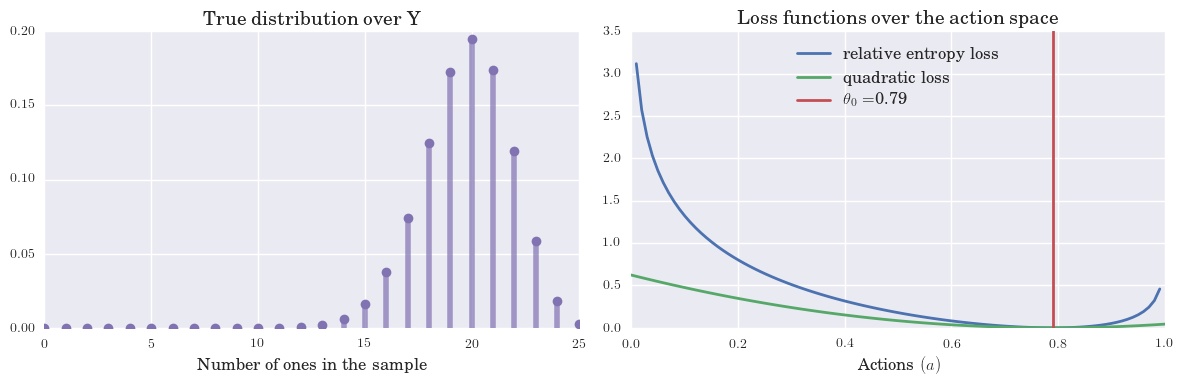

In [4]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].set_title('True distribution over Y', fontsize = 14)
ax[0].plot(y_grid, true_dist.pmf(y_grid), 'o', color = sns.color_palette()[3])
ax[0].vlines(y_grid, 0, true_dist.pmf(y_grid), lw = 4, color = sns.color_palette()[3], alpha = .7)
ax[0].set_xlabel(r'Number of ones in the sample', fontsize = 12)

ax[1].set_title('Loss functions over the action space', fontsize = 14)
ax[1].plot(a_grid, rel_ent, lw = 2, label = 'relative entropy loss')
ax[1].plot(a_grid, quadratic, lw = 2, label = 'quadratic loss')
ax[1].axvline(theta0, color = sns.color_palette()[2], lw = 2, label = r'$\theta_0=${t}'.format(t=theta0))
ax[1].legend(loc = 'best', fontsize = 12)
ax[1].set_xlabel(r'Actions $(a)$', fontsize = 12)
plt.tight_layout()

plt.savefig("./example1_fig1.png", dpi=800)

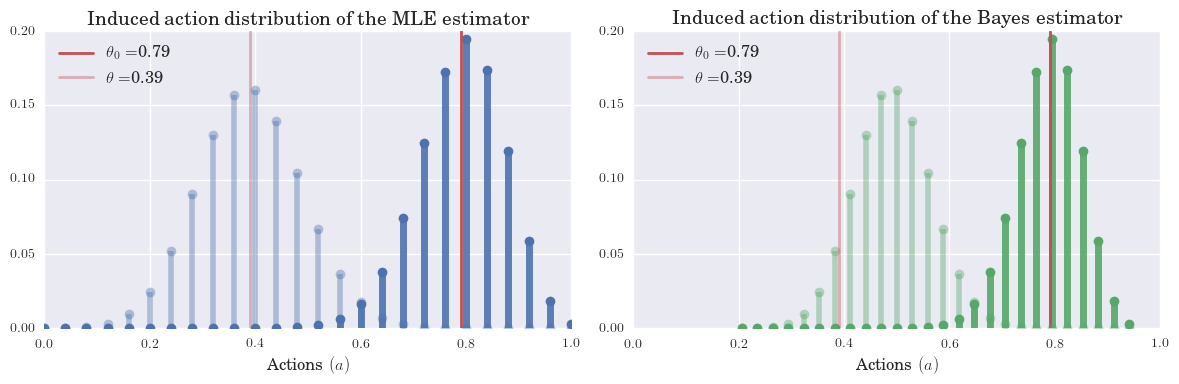

In [5]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].set_title('Induced action distribution of the MLE estimator', fontsize = 14)
# Small bias
ax[0].plot(decision_rule, true_dist.pmf(y_grid), 'o')
ax[0].vlines(decision_rule, 0, true_dist.pmf(y_grid), lw = 5, alpha = .9, color = sns.color_palette()[0])
ax[0].axvline(theta0, color = sns.color_palette()[2], lw = 2, label = r'$\theta_0=${t}'.format(t=theta0))
# Large bias for Bayes
ax[0].plot(decision_rule, true_dist_alt.pmf(y_grid), 'o', color = sns.color_palette()[0], alpha = .4)
ax[0].vlines(decision_rule, 0, true_dist_alt.pmf(y_grid), lw = 4, alpha = .4, color = sns.color_palette()[0])
ax[0].axvline(theta0_alt, color = sns.color_palette()[2], lw = 2, alpha = .4, 
              label = r'$\theta=${t}'.format(t=theta0_alt))
ax[0].legend(loc = 'best', fontsize = 12)
ax[0].set_ylim([0, .2])
ax[0].set_xlim([0, 1])
ax[0].set_xlabel(r'Actions $(a)$', fontsize = 12)

ax[1].set_title('Induced action distribution of the Bayes estimator', fontsize = 14)
# Small bias
ax[1].plot(decision_rule_bayes, true_dist.pmf(y_grid), 'o', color = sns.color_palette()[1])
ax[1].vlines(decision_rule_bayes, 0, true_dist.pmf(y_grid), lw = 5, alpha = .9, 
                color = sns.color_palette()[1])
ax[1].axvline(theta0, color = sns.color_palette()[2], lw = 2, label = r'$\theta_0=${t}'.format(t=theta0))
# Large bias for Bayes
ax[1].plot(decision_rule_bayes, true_dist_alt.pmf(y_grid), 'o', color = sns.color_palette()[1], alpha = .4)
ax[1].vlines(decision_rule_bayes, 0, true_dist_alt.pmf(y_grid), lw = 4, alpha = .4, 
                color = sns.color_palette()[1])
ax[1].axvline(theta0_alt, color = sns.color_palette()[2], lw = 2, alpha = .4, 
              label = r'$\theta=${t}'.format(t=theta0_alt))
ax[1].legend(loc = 'best', fontsize = 12)
ax[1].set_ylim([0, .2])
ax[1].set_xlim([0, 1])
ax[1].set_xlabel(r'Actions $(a)$', fontsize = 12)

plt.tight_layout()
plt.savefig("./example1_fig2.png", dpi=800)

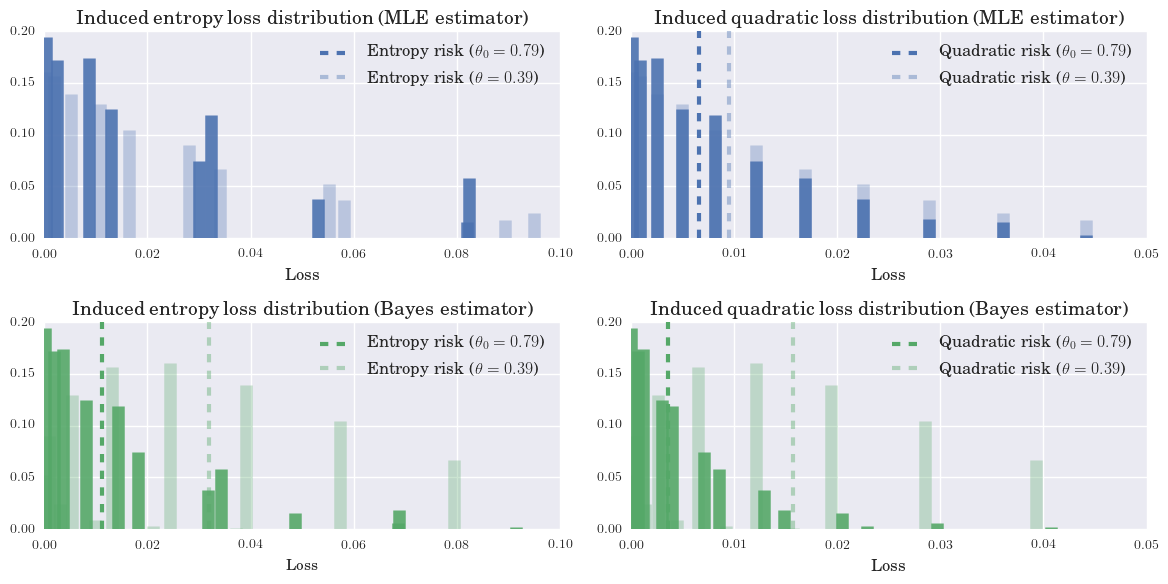

In [6]:
fig, ax = plt.subplots(2, 2, figsize = (12, 6))

ax[0, 0].set_title('Induced entropy loss distribution (MLE estimator)', fontsize = 14)
ax[0, 0].vlines(loss_re_mle, 0, loss_dist_re_mle, lw = 9, alpha = .9, color = sns.color_palette()[0]) 
ax[0, 0].axvline(risk_re_mle, lw = 3, linestyle = '--',
                     color = sns.color_palette()[0], label = r"Entropy risk ($\theta_0={t}$)".format(t=theta0))
ax[0, 0].vlines(loss_re_mle_alt, 0, loss_dist_re_mle_alt, lw = 9, alpha = .3, color = sns.color_palette()[0]) 
ax[0, 0].axvline(risk_re_mle_alt, lw = 3, linestyle = '--', alpha = .4,
                     color = sns.color_palette()[0], label = r"Entropy risk ($\theta={t}$)".format(t=theta0_alt))

ax[0, 0].set_xlim([0, .1])
ax[0, 0].set_ylim([0, .2])
ax[0, 0].set_xlabel('Loss', fontsize=12)
ax[0, 0].legend(loc = 'best', fontsize = 12)
    
ax[1, 0].set_title('Induced entropy loss distribution (Bayes estimator)', fontsize=14)
ax[1, 0].vlines(loss_re_bayes, 0, loss_dist_re_bayes, lw=9, alpha=.9, color=sns.color_palette()[1]) 
ax[1, 0].axvline(risk_re_bayes, lw=3, linestyle='--',
                     color = sns.color_palette()[1], label=r"Entropy risk ($\theta_0={t}$)".format(t=theta0))
ax[1, 0].vlines(loss_re_bayes_alt, 0, loss_dist_re_bayes_alt, lw=9, alpha=.3, color=sns.color_palette()[1]) 
ax[1, 0].axvline(risk_re_bayes_alt, lw=3, linestyle='--', alpha=.4, color=sns.color_palette()[1], 
                 label=r"Entropy risk ($\theta={t}$)".format(t=theta0_alt))
ax[1, 0].set_xlim([0, .1])
ax[1, 0].set_ylim([0, .2])
ax[1, 0].set_xlabel('Loss')
ax[1, 0].legend(loc='best', fontsize=12)

ax[0, 1].set_title('Induced quadratic loss distribution (MLE estimator)', fontsize=14)
ax[0, 1].vlines(loss_quad_mle, 0, loss_dist_quad_mle, lw=9, alpha=.9, color=sns.color_palette()[0]) 
ax[0, 1].axvline(risk_quad_mle, lw=3, linestyle='--', 
                     color = sns.color_palette()[0], label=r"Quadratic risk ($\theta_0={t}$)".format(t=theta0))
ax[0, 1].vlines(loss_quad_mle_alt, 0, loss_dist_quad_mle_alt, lw=9, alpha=.3, color=sns.color_palette()[0]) 
ax[0, 1].axvline(risk_quad_mle_alt, lw=3, linestyle='--', alpha=.4,
                     color=sns.color_palette()[0], label=r"Quadratic risk ($\theta={t}$)".format(t=theta0_alt))
ax[0, 1].set_xlim([0, .05])
ax[0, 1].set_ylim([0, .2])
ax[0, 1].set_xlabel('Loss', fontsize=12)
ax[0, 1].legend(loc='best', fontsize=12)
    
ax[1, 1].set_title('Induced quadratic loss distribution (Bayes estimator)', fontsize=14)
ax[1, 1].vlines(loss_quad_bayes, 0, loss_dist_quad_bayes, lw=9, alpha=.9, color=sns.color_palette()[1]) 
ax[1, 1].axvline(risk_quad_bayes, lw=3, linestyle='--', 
                     color = sns.color_palette()[1], label=r"Quadratic risk ($\theta_0={t}$)".format(t=theta0))
ax[1, 1].vlines(loss_quad_bayes_alt, 0, loss_dist_quad_bayes_alt, lw=9, alpha=.3, color=sns.color_palette()[1]) 
ax[1, 1].axvline(risk_quad_bayes_alt, lw=3, linestyle = '--', alpha=.4,
                     color=sns.color_palette()[1], label=r"Quadratic risk ($\theta={t}$)".format(t=theta0_alt))
ax[1, 1].set_xlim([0, .05])
ax[1, 1].set_ylim([0, .2])
ax[1, 1].set_xlabel('Loss', fontsize=12)
ax[1, 1].legend(loc='best', fontsize=12)

plt.tight_layout()
plt.savefig("./example1_fig3.png", dpi=800)

**Bayes OLS example**

In [19]:
mu = np.array([1, 3])                    # mean
sigma = np.array([[4, 1], [1, 8]])       # covariance matrix
n = 50                                   # sample size

# Bayes priors
mu_bayes = np.array([2.5, 1.5])
precis_bayes = np.array([[6, -3], [-3, 6]])

np.random.seed(123)

# joint normal rv for (Y,X)
mvnorm = multivariate_normal(mu, sigma)

# decision rule -- OLS estimator
def d_OLS(Z, n):
    Y = Z[:, 0]
    X = np.stack((np.ones(n), Z[:,1]), axis=-1)
    return np.linalg.inv(X.T @ X) @ X.T @ Y

# decision rule -- Bayes
def d_bayes(Z, n):
    Y = Z[:, 0]
    X = np.stack((np.ones(n), Z[:,1]), axis=-1)
    return np.linalg.inv(X.T @ X + precis_bayes) @ (precis_bayes @ mu_bayes + X.T @ Y)

# loss -- define integrand
def loss_int(y, x, b):
    '''Defines the integrand under mvnorm distribution.'''
    return (y - b[0] - b[1]*x)**2*mvnorm.pdf((y,x))

# simulate distribution over actions and over losses
B_OLS = []
L_OLS = []
B_bayes = []
L_bayes = []

for i in range(1000):
    # generate sample
    Z = mvnorm.rvs(n)
    
    # get OLS action corrsponding to realized sample
    b_OLS = d_OLS(Z, n)
    
    # get Bayes action
    b_bayes = d_bayes(Z, n)
    
    # get loss through integration
    l_OLS = dblquad(loss_int, -np.inf, np.inf, lambda x: -np.inf, lambda x: np.inf, args=(b_OLS,)) 
    l_bayes = dblquad(loss_int, -np.inf, np.inf, lambda x: -np.inf, lambda x: np.inf, args=(b_bayes,))
    
    # record action
    B_OLS.append(b_OLS)
    B_bayes.append(b_bayes)
    
    # record loss
    L_OLS.append(l_OLS)
    L_bayes.append(l_bayes)

# take first column if integrating    
L_OLS = np.array(L_OLS)[:, 0]
L_bayes = np.array(L_bayes)[:, 0]


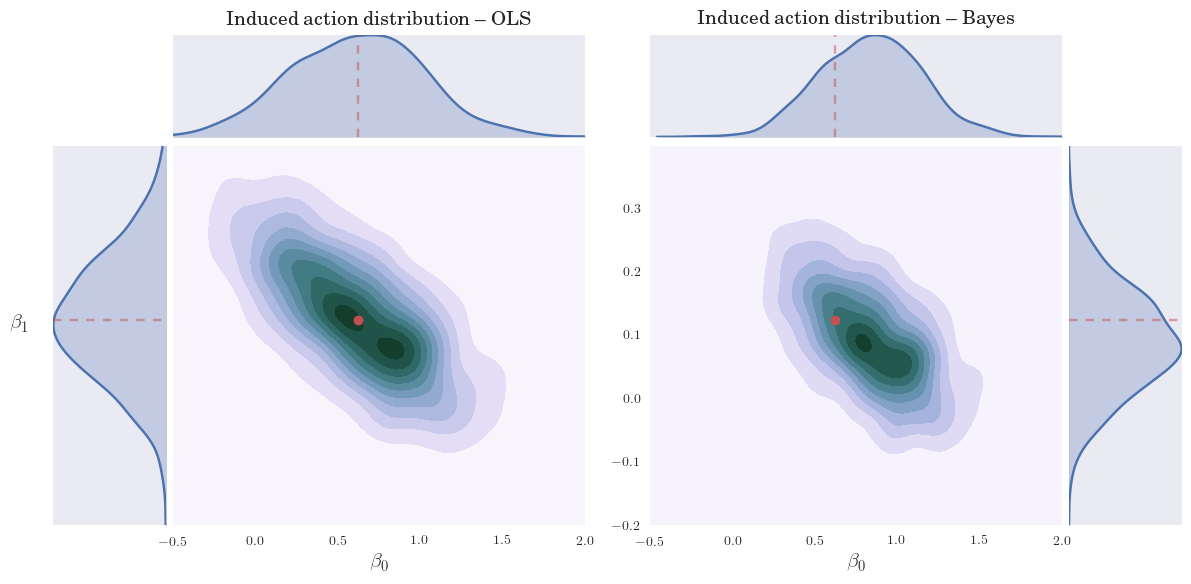

In [36]:
data = np.asarray(B_OLS).T
data2 = np.asarray(B_bayes).T

xmin, ymin = -.5, -.2
xmax, ymax = 2, .4

#xmin, ymin = data.min(axis=1)
#xmax, ymax = data.max(axis=1)

#xmax, xmin = tuple(np.array([xmax, xmin]) + 0.1*(xmax - xmin)*np.array([1, -1]))
#ymax, ymin = tuple(np.array([ymax, ymin]) + 0.1*(ymax - ymin)*np.array([1, -1]))

cmap = sns.cubehelix_palette(start=2, light=1, as_cmap=True)

f = plt.figure(figsize = (12, 6))
gs0 = gsp.GridSpec(1, 2)

gs00 = gsp.GridSpecFromSubplotSpec(9, 9, subplot_spec=gs0[0])

ax1_t = plt.Subplot(f, gs00[:2, 2:], yticks=[], xticks=[], xlim=(xmin, xmax))
ax1_l = plt.Subplot(f, gs00[2:, :2], yticks=[], xticks=[], ylim=(ymin, ymax))
ax1_c = plt.Subplot(f, gs00[2:, 2:], yticks=[], xlim=(xmin, xmax), ylim=(ymin, ymax))

gs01 = gsp.GridSpecFromSubplotSpec(9, 9, subplot_spec=gs0[1])

ax2_t = plt.Subplot(f, gs01[:2, :-2], yticks=[], xticks=[], xlim=(xmin, xmax))
ax2_r = plt.Subplot(f, gs01[2:, -2:], xticks=[], yticks=[], ylim=(ymin, ymax))
ax2_c = plt.Subplot(f, gs01[2:, :-2], xlim=(xmin, xmax), ylim=(ymin, ymax))

sns.kdeplot(data[0], data[1], cmap=cmap, shade=True, cut=3, ax=ax1_c)
ax1_c.plot([mu[0] - sigma[0,1]/sigma[1,1]*mu[1]], [sigma[0,1]/sigma[1,1]], 'ro', color=colors[2])
ax1_c.yaxis.tick_right()
ax1_c.set_xlabel(r'$\beta_0$', fontsize=15)

sns.kdeplot(data2[0], data2[1], cmap=cmap, shade=True, cut=5, ax=ax2_c)
ax2_c.plot([mu[0] - sigma[0,1]/sigma[1,1]*mu[1]], [sigma[0,1]/sigma[1,1]], 'ro', color=colors[2])
#ax2_c.yaxis.tick_right()
ax2_c.set_xlabel(r'$\beta_0$', fontsize=15)

#Create Y-marginal (left)
sns.distplot(data[1], hist=False, color=colors[0], kde_kws={"shade": True}, ax=ax1_l, vertical=True)
ax1_l.set_ylabel(r'$\beta_1$', fontsize=15, rotation=0)
ax1_l.yaxis.set_label_coords(-.3, .5)
ax1_l.axes.invert_xaxis()
ax1_l.axhline(sigma[0,1]/sigma[1,1], color = colors[2], alpha=.5, linestyle='--')

#Create Y-marginal (right)
sns.distplot(data2[1], hist=False, color=colors[0], kde_kws={"shade": True}, ax=ax2_r, vertical=True)
ax2_r.axhline(sigma[0,1]/sigma[1,1], color = colors[2], alpha=.5, linestyle='--')

#Create X-marginal (top)
sns.distplot(data[0], hist=False, color=colors[0], kde_kws={"shade": True}, ax=ax1_t)
sns.distplot(data2[0], hist=False, color=colors[0], kde_kws={"shade": True}, ax=ax2_t)
ax1_t.axvline(mu[0] - sigma[0,1]/sigma[1,1]*mu[1], color = colors[2], alpha=.5, linestyle='--')
ax2_t.axvline(mu[0] - sigma[0,1]/sigma[1,1]*mu[1], color = colors[2], alpha=.5, linestyle='--')
ax1_t.set_title('Induced action distribution -- OLS', fontsize=14, y=1.04)
ax2_t.set_title('Induced action distribution -- Bayes', fontsize=14, y=1.04)

f.add_subplot(ax1_t)
f.add_subplot(ax1_l)
f.add_subplot(ax1_c)

f.add_subplot(ax2_t)
f.add_subplot(ax2_r)
f.add_subplot(ax2_c)

f.tight_layout()
plt.savefig("./example2_fig1.png", dpi=800)

<!---
data = np.asarray(B_OLS).T
data2 = np.asarray(B_bayes).T

xmin, ymin = data.min(axis=1)
xmax, ymax = data.max(axis=1)

xmax, xmin = tuple(np.array([xmax, xmin]) + 0.05*(xmax - xmin)*np.array([1, -1]))
ymax, ymin = tuple(np.array([ymax, ymin]) + 0.05*(ymax - ymin)*np.array([1, -1]))

#Define grid for subplots
gs = gsp.GridSpec(2, 4, width_ratios=[1, 6, 6, 1], height_ratios = [1, 6])
cmap = sns.cubehelix_palette(start=2, light=1, as_cmap=True)

fig = plt.figure(figsize = (11, 6))

#Create contour plot_left
ax = plt.subplot(gs[1, 1], xlim = (xmin, xmax), ylim = (ymin, ymax)) 
sns.kdeplot(data[0], data[1], cmap=cmap, shade=True, cut=5, ax=ax)
ax.plot([mu[0] - sigma[0,1]/sigma[1,1]*mu[1]], [sigma[0,1]/sigma[1,1]], 'ro', color=colors[2])
ax.yaxis.tick_right()
ax.set_xlabel(r'$\beta_0$', fontsize=15)
ax.yaxis.set_label_position("right")

#Create contour plot_right
ax2 = plt.subplot(gs[1, 2], sharey=ax, yticks=[], xlim = (xmin, xmax), ylim = (ymin, ymax)) 
sns.kdeplot(data2[0], data2[1], cmap=cmap, shade=True, cut=5, ax=ax2)
ax2.plot([mu[0] - sigma[0, 1]/sigma[1, 1]*mu[1]], 
        [sigma[0, 1]/sigma[1, 1]], 'ro', color=colors[2])
ax2.set_xlabel(r'$\beta_0$', fontsize=15)

#Create Y-marginal (left)
axl = plt.subplot(gs[1, 0], xticks=[], yticks=[], ylim = (ymin, ymax)) 
sns.distplot(data[1], hist=False, color=colors[0], kde_kws={"shade": True}, ax=axl, vertical=True)
axl.set_ylabel(r'$\beta_1$', fontsize=15, rotation=0)
axl.yaxis.set_label_coords(-.3, .5)
axl.axes.invert_xaxis()

#Create Y-marginal (right)
axr = plt.subplot(gs[1, 3], xticks=[], yticks=[], ylim = (ymin, ymax)) 
sns.distplot(data2[1], hist=False, color=colors[0], kde_kws={"shade": True}, ax=axr, vertical=True)

#Create X-marginal (top)
axt = plt.subplot(gs[0, 1], xticks=[], yticks=[], xlim=(xmin, xmax))
sns.distplot(data[0], hist=False, color=colors[0], kde_kws={"shade": True}, ax=axt)

axt2 = plt.subplot(gs[0, 2], xticks=[], yticks=[], xlim=(xmin, xmax))
sns.distplot(data2[0], hist=False, color=colors[0], kde_kws={"shade": True}, ax=axt2)

#Bring the marginals closer to the scatter plot
axt.set_title('Induced action distribution -- OLS', fontsize=14, y=1.04)
axt2.set_title('Induced action distribution -- Bayes', fontsize=14, y=1.04)
fig.tight_layout(pad=0.4, w_pad=.3, h_pad=.5)
--->

In [21]:
b_best = [mu[0] - sigma[0,1]/sigma[1,1]*mu[1], sigma[0,1]/sigma[1,1]]
l_best = dblquad(loss_int, -np.inf, np.inf, lambda x: -np.inf, lambda x: np.inf, args=(b_best,))
print(l_best[0])

3.8749999999509477


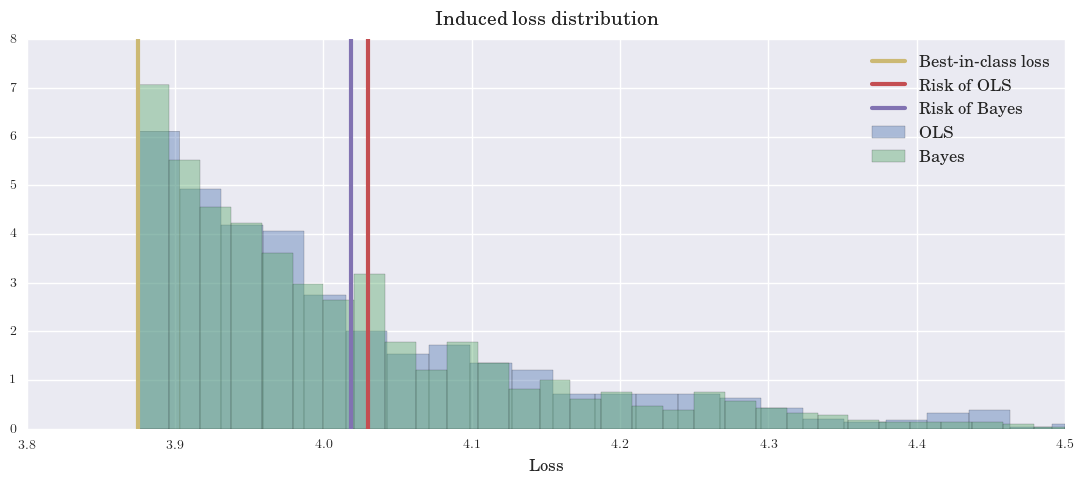

In [22]:
plt.figure(figsize=(11, 5))
plt.axvline(x=l_best[0], ymin=0, ymax=1, linewidth=3, color = colors[4], label='Best-in-class loss')
plt.axvline(x=L_OLS.mean(), ymin=0, ymax=1, linewidth=3, color = colors[2], label='Risk of OLS')
plt.axvline(x=L_bayes.mean(), ymin=0, ymax=1, linewidth=3, color = colors[3], label='Risk of Bayes')
sns.distplot(L_OLS, bins=50, kde=False, norm_hist=True, color = colors[0], label='OLS')
sns.distplot(L_bayes, bins=50, kde=False, norm_hist=True, color = colors[1], label='Bayes')
plt.title('Induced loss distribution', fontsize = 14, y=1.02)
plt.legend(fontsize=12)
plt.xlabel('Loss', fontsize=12)
plt.xlim([3.8, 4.5])
plt.tight_layout()

plt.savefig("./example2_fig2.png", dpi=800)

In [25]:
beta_0 = mu[0] - sigma[0,1]/sigma[1,1]*mu[1]
beta_1 = sigma[0,1]/sigma[1,1]

print('Bias of OLS')
print('==========================')
print('{:.4f} - {:.4f} = {:.4f}'.format(beta_0, np.asarray(B_OLS).mean(0)[0], beta_0 - np.asarray(B_OLS).mean(0)[0]))
print('{:.4f} - {:.4f} = {:.4f}\n\n'.format(beta_1, np.asarray(B_OLS).mean(0)[1], beta_1 - np.asarray(B_OLS).mean(0)[1]))

print('Bias of Bayes')
print('==========================')
print('{:.4f} - {:.4f} = {:.4f}'.format(beta_0, np.array(B_bayes).mean(0)[0], beta_0 - np.array(B_bayes).mean(0)[0]))
print('{:.4f} - {:.4f} = {:.4f}'.format(beta_1, np.array(B_bayes).mean(0)[1], beta_1 - np.array(B_bayes).mean(0)[1]))

Bias of OLS
0.6250 - 0.6150 = 0.0100
0.1250 - 0.1289 = -0.0039


Bias of Bayes
0.6250 - 0.8401 = -0.2151
0.1250 - 0.0928 = 0.0322


In [26]:
print('Variance of OLS')
print('======================')
print(np.asarray(B_OLS).var(0))

print('\n\nVarinace of Bayes')
print('======================')
print(np.asarray(B_bayes).var(0))

Variance of OLS
[ 0.15862101  0.00974428]


Varinace of Bayes
[ 0.09106176  0.00705757]


In [27]:
print('Risk of OLS:   {:.4f} \nRisk of Bayes: {:.4f}'.format(L_OLS.mean(), L_bayes.mean()))

Risk of OLS:   4.0298 
Risk of Bayes: 4.0188
